# Beautif.ai classification

The goal of your project is to create a robust classifier, to collect data and prepare custom dataset.  
You will build a model that will recognize 4 types of natural events in nature/indoor/outdoor:

* Daylight sky 
  * <img src = "https://ak.picdn.net/shutterstock/videos/7077064/thumb/1.jpg" width = "50%" height="50%">
* Sky at night
  * <img src="https://i.pinimg.com/originals/ec/98/dd/ec98dd97904e60661b1d545a88006e6a.jpg" width="50%" height="50%"/>

* Picture doesn't contain sky (no matter it's day or night)
  * <img src= "https://www.hotelsolun.com/application/files/5515/6285/1004/1X9A8812.jpg" width="50%" height="50%"/>


This project consists of the following activities :


1. Phase 1 : Dataset
    * Team Planning
    * Full git project Integration
    * General Project Research
    * Dataset Collection
    * Dataset Preparation
2. Phase 2 : Training
    * Research about neural networks
    * Compose neural network architectures
    * Ping Pong phase with Dataset labelers
    * Generate syntethic data if needed
    * Fine tunning of your model
3. Phase 3 : Deployment
    * Analysis and benchmark Precision/Recall
    * Model Deploy (Git)
    * Write git Readme.md file
    * Receive Feedback from PM


# Load Data

In [4]:
import os
#from google.colab import drive
from PIL import Image
import shutil
import random
import cv2
from keras.applications.xception import preprocess_input as X_pre
from keras.applications.resnet50 import preprocess_input as Res_pre
import numpy as np

from sklearn.datasets import load_files  
import numpy as np
from keras.utils import np_utils
import cv2

import keras
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.applications.xception import Xception
from keras.applications.densenet import DenseNet169
from keras.applications.resnet import ResNet50
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Activation, Conv2D, Flatten, MaxPooling2D, AveragePooling2D, Dropout, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt

plt.style.use( "ggplot" )

In [3]:
#drive.mount('/content/drive')

In [5]:
def split_test_valid( split_ratio, set_path, random_seed = 1, print_ratio = False, include_path = True ) :

    """
    This functions lists through a directory containing different sets in sorted subdirectories and returns test_x, valid_x, test_labels, valid_labels ( or x and y ) for further use.
    The arguments that need to be provided:
        split_ratio: is the ratio for the data set to be split along. Acceptable input is a float between 0 and 1 i.e. the percentage needed for further use; 
        set_path: is the path to the main directory where the subdirectories are located.
    Optional arguments:
         random_seed: is self-explanatory;
         print_ratio: prints the int ratio of the split.
         include_path: whether or not to include the full path in the train and test sets.
            If True returns: '/content/drive/MyDrive/Directory/Subdirectiory/Image.jpg';
            If False returns: 'Image.jpg'.

    *DK
    """

    random.seed( random_seed )
    
    total = 0

    test_x = []
    valid_x = []
    test_labels = []
    valid_labels = []

    if set_path[ -1 ] == "/" :
        set_path = set_path[0:-1]

    os.chdir( set_path )
    list_dir = os.listdir()

    for folder in list_dir :
        os.chdir( f'{ set_path}/{ folder }' )
        how_many =  len( os.listdir() )
        total += how_many

        test_set = int( round( how_many * ( 1 - split_ratio ), 0 ) )
        valid_set = int( round( how_many * split_ratio, 0 ) )

        nums = [ x for x in range( 1, how_many ) ]
        random_nums = random.sample( nums, valid_set )

        # The split itself :
        for ind, item in enumerate( os.listdir() ):

            if ind in random_nums :
                if include_path == True :
                    valid_x.append( f"{set_path}/{folder}/{item}" )
                elif include_path == False :
                    valid_x.append( item )

                valid_labels.append( folder )

            if ind not in random_nums :

                if include_path == True :
                    test_x.append( f"{set_path}/{folder}/{item}" )
                elif include_path == False :
                    test_x.append( item )

                test_labels.append( folder )

        if print_ratio == True :

            print( f"Set: { folder } - { how_many } items" )
            print( f"Train: { test_set }" )
            print( f"Validation: { valid_set }" )
            print( f"Total: { test_set + valid_set }" )
            print( "---------" )
        elif print_ratio == False :
            pass
    
    if print_ratio == True :
        test_set = int( round( total * ( 1 - split_ratio ), 0 ) )
        valid_set = int( round( total * split_ratio, 0 ) )

        print( "---------" ) 
        print( f"United set: { total } items" )
        print( f"Train: { test_set }" )
        print( f"Validation: { valid_set }" )
        print( f"Total: { test_set + valid_set }" )
        print( "---------" )
    elif print_ratio == False :
            pass

    return test_x, valid_x, test_labels, valid_labels

In [27]:
set_path = "C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224"
split_ratio = 0.15

train_x, validation_x, train_labels, validation_labels  = split_test_valid( split_ratio, set_path, random_seed = 42, print_ratio = True )

Set: Day - 3308 items
Train: 2812
Validation: 496
Total: 3308
---------
Set: Night-Not_Separated - 879 items
Train: 747
Validation: 132
Total: 879
---------
Set: Night-Separated - 627 items
Train: 533
Validation: 94
Total: 627
---------
Set: No_Sky - 3826 items
Train: 3252
Validation: 574
Total: 3826
---------
---------
United set: 8640 items
Train: 7344
Validation: 1296
Total: 8640
---------


In [24]:
train_labels = np.array( train_labels )
validation_labels = np.array( validation_labels )

# Visualize Data Distribution

In [26]:
 os.chdir( 'C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated' )
# print( os.getcwd() ) 

COUNT = 1
  
def increment(): 
    global COUNT 
    COUNT = COUNT + 1

for f in os.listdir(): 
    f_name, f_ext = os.path.splitext( f ) 
    f_name = str( COUNT ) 
    increment() 
  
    new_name = 'night_{}{}'.format( f_name, f_ext.lower() ) 
    os.rename( f, new_name )

# Image Preprocessing

In [28]:
def load_image( path ) :
  # READ AND PREPROCESS IMAGE HERE
  #cv2.imread
  print(path)
  image = cv2.imread( path ).astype( np.float32 )
  image_resized = X_pre( image )
  return image_resized

def load_dataset( files ) :
  vector = []
  brojcanik = 0
  for file in files:
    brojcanik = brojcanik + 1
    vector.append( load_image( file ) )
    if brojcanik%100 == 0:
      print(f"procesirani se vkupno {brojcanik} sliki")
    
  return np.array( vector )


X_train = load_dataset( train_x )
X_val = load_dataset( validation_x )

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d1000_personal (1)_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d1000_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d1001_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d1004_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d1005_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d1007_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d1009_personal_resized

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d1124_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d1125_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d1126_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d1127_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d1128_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d112_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d1130_personal_resized.jpg


C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d1216_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d1217_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d1218_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d1219_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d1220_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d1223_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d1226_personal_resized.jpg

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d220_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d225_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d22_personal_resized.jpg
procesirani se vkupno 200 sliki
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d233_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d235_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d236_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d37_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d394_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d395_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d396_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d398_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d39_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d3_personal_resized.jpg
C:/Users/d

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d521_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d522_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d523_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d524_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d526_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d527_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d528_personal_resized.jpg
C:/Use

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d665_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d66_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d670_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d671_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d67_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d683_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d684_personal_resized.jpg
procesir

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d790_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d792_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d793_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d794_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d795_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d79_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d802_personal_resized.jpg
C:/User

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d886_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d889_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d891_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d892_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d894_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d895_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d896_personal_resized.jpg
C:/Use

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/i128_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/i129_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/i130_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/i131_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/i132_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/i133_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/i134_personal_resized.jpg
C:/Use

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/i97_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/i99_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/j102_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/j103_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/j104_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/j105_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/j107_personal_resized.jpg
C:/Users

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/j184_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/j185_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/j186_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/j187_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/j188_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/j189_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/j18_personal_resized.jpg
C:/User

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/j80_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/j81_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/j84_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/j85_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/j86_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/j87_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/j88_personal_resized.jpg
C:/Users/dkjo

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/p89_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/p8_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/p90_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/p91_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/p92_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/p93_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/p94_personal_resized.jpg
C:/Users/dkjos

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_10906_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_10921_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_10923_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_10940_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_10959_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_1096_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_10979_resiz

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_12376_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_12419_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_12489_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_12509_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_12511_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_12532_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_12575_resi

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_13566_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_13581_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_13593_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_13610_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_13634_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_13637_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_13665_resi

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_14660_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_14664_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_14671_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_1471_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_14755_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_14769_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_14788_resiz

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_15582_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_1558_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_15596_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_1559_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_15610_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_15611_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_15612_resize

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_16509_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_16534_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_16541_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_16549_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_165_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_16610_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_1662_resized

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_18160_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_18185_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_18188_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_18202_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_18248_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_18261_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_18269_resi

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_19695_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_19740_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_19751_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_19786_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_19794_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_19801_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_19803_resi

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_2097_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_21016_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_21045_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_21070_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_21097_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_21122_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_21163_resiz

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_22715_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_22751_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_22755_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_22757_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_2279_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_22812_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_22813_resiz

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_24259_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_24317_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_24332_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_24367_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_24369_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_24370_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_24373_resi

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_25622_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_25630_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_25632_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_25638_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_25640_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_25671_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_25673_resi

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_26980_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_27031_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_27088_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_27129_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_27145_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_27158_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_27208_resi

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_28622_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_28631_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_28645_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_28704_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_28753_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_28762_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_28787_resi

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_30502_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_30512_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_30563_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_3057_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_30592_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_30626_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_30634_resiz

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_32367_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_32390_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_32391_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_32393_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_32422_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_32432_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_32442_resi

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_33899_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_33908_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_33945_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_33962_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_33970_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_34037_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_34043_resi

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_430_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_4334_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_4355_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_4363_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_4365_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_4369_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_4438_resized.jpg


C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_5707_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_5747_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_580_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_5822_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_5848_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_586_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_5899_resized.jpg
C

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_7326_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_7327_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_7329_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_739_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_7408_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_7449_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_7455_resized.jpg


C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_8459_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_8464_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_8489_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_8547_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_8548_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_8554_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_8555_resized.jpg

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/t_102_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/t_103_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/t_105_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/t_109_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/t_10_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/t_114_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/t_115_personal_resized.jpg


C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/t_201_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/t_203_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/t_204_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/t_205_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/t_206_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/t_207_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/t_208_personal_resized.jpg

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/t_285_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/t_286_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/t_287_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/t_291_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/t_292_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/t_293_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/t_294_personal_resized.jpg

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/t_429_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/t_430_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/t_431_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/t_434_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/t_436_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/t_438_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/t_439_personal_resized.jpg

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/t_544_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/t_545_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/t_546_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/t_547_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/t_548_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/t_549_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/t_54_personal_resized.jpg


C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/t_641_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/t_643_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/t_644_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/t_645_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/t_647_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/t_649_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/t_650_personal_resized.jpg

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_118.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_119.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_12.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_120.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_122.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_123.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resiz

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_180.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_181.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_182.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_183.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_184.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_185.jpg
procesirani se vkupno 2900 sliki
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brain

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_25.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_250.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_251.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_252.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_253.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_254.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resiz

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_328.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_329.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_33.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_330.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_331.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_332.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resiz

procesirani se vkupno 3100 sliki
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_40.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_401.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_403.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_406.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_407.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_408.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brains

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_47.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_470.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_472.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_473.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_475.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_476.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resiz

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_544.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_545.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_546.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_547.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_548.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_549.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resi

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_603.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_604.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_606.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_607.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_608.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_609.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resi

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_669.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_67.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_670.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_672.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_673.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_674.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resiz

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_738.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_739.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_74.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_740.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_741.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_743.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resiz

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_801.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_802.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_803.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_804.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_805.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_806.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resi

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_868.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_869.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_87.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_872.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_873.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_874.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resiz

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_143.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_144.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_145.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_147.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_148.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_149.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_15.jpg
C:/User

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_207.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_208.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_209.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_21.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_210.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_212.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_213.jpg
C:/User

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_270.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_271.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_272.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_273.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_274.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_275.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_276.jpg
C:/Use

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_334.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_335.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_336.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_337.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_338.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_34.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_340.jpg
C:/User

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_394.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_396.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_397.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_398.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_399.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_4.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_40.jpg
C:/Users/

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_457.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_458.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_460.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_461.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_462.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_463.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_464.jpg
C:/Use

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_525.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_526.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_527.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_529.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_531.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_532.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_533.jpg
C:/Use

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_590.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_591.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_592.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_593.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_594.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_595.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_596.jpg
C:/Use

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_89.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_9.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_90.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_91.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_92.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_94.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_95.jpg
C:/Users/dkjos

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/d1120_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/d1129_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/d1143_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/d1159_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/d1160_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/d1168_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/d116_

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/d285_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/d286_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/d292_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/d293_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/d294_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/d298_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/d303_person

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/d461_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/d463_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/d467_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/d468_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/d470_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/d471_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/d486_person

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/d591_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/d592_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/d594_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/d595_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/d596_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/d597_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/d598_person

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/d754_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/d755_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/d756_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/d75_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/d76_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/d783_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/d789_personal

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/d956_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/d957_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/d95_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/d964_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/d966_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/d969_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/d96_personal

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_10073_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_10088_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_10111_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_1011_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_10132_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_1013_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/P

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_10645_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_10652_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_10654_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_10665_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_10666_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_10669_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_11349_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_11351_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_11357_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_1136_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_11407_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_11414_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_12056_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_12070_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_12085_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_12088_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_12101_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_12122_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_12776_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_12791_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_12809_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_12810_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_12821_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_12828_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_13478_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_13480_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_13481_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_13484_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_13498_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_13500_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_14040_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_14050_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_14064_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_14071_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_1407_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_14084_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_14593_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_14600_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_1461_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_14621_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_14630_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_14631_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_15257_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_15262_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_15275_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_15291_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_15322_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_15324_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_15843_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_15850_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_15854_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_1587_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_15883_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_15888_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_16454_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_16462_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_16479_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_16483_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_16494_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_1649_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_1720_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_17239_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_17262_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_17291_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_17299_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_17305_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_17780_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_17783_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_17786_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_17790_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_17792_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_17812_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_18471_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_18479_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_18501_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_1850_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_18516_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_1851_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/P

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_19205_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_19209_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_19219_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_19228_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_19235_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_1923_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_19782_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_19802_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_19808_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_19812_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_19815_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_19817_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_20452_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_2045_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_20477_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_2047_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_20504_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_20508_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/P

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_21123_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_21128_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_21135_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_21140_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_2116_resized.jpg
procesirani se vkupno 5500 sliki
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_21189_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifa

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_21716_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_2171_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_21725_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_21727_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_21748_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_21752_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_22271_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_22284_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_22287_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_222_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_22307_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_22311_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/P

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_22857_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_2285_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_22882_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_22898_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_22901_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_22903_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_23576_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_23577_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_23585_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_23589_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_23605_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_2368_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_24499_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_24518_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_24521_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_24528_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_24532_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_24535_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_25219_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_25226_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_25238_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_25256_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_25259_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_2525_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_25890_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_25909_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_2591_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_2593_resized.jpg
procesirani se vkupno 5900 sliki
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_25944_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_25945_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_26405_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_26425_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_26439_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_26443_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_26458_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_26461_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_27083_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_27098_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_27102_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_27114_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_27175_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_27181_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_27943_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_27975_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_27977_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_27989_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_28021_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_28025_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_28730_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_28732_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_28750_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_28761_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_28773_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_28807_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_29522_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_29525_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_29542_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_29554_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_29566_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_29567_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_30097_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_30102_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_30107_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_30119_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_30122_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_30130_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_30725_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_30730_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_30752_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_30769_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_30777_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_30780_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_31494_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_31541_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_31549_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_31552_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_31559_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_31560_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_32160_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_32178_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_321_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_32203_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_32211_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_32212_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/P

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_3275_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_32765_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_32779_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_32823_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_32865_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_32873_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_33535_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_33563_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_33576_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_33616_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_33623_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_33633_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_34144_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_34145_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_34147_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_34157_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_34158_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_34182_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_3618_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_3638_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_3639_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_3660_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_3662_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_3664_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Place

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_4342_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_4354_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_4357_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_4359_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_4366_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_4372_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Place

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_4876_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_4898_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_4903_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_4917_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_4928_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_4948_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Place

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_5529_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_5535_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_555_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_5567_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_5568_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_5608_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_6152_resized.jpg
procesirani se vkupno 6900 sliki
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_6167_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_6168_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_6176_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_6179_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_617_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labe

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_6835_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_6848_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_6858_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_6861_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_6870_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_689_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_7502_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_7510_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_7529_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_7538_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_7571_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_7572_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Place

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_822_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_8230_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_8238_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_8239_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_8243_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_8251_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_8779_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_8800_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_8807_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_8828_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_8845_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_8847_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Place

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_9493_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_9498_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_9499_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_9507_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_9512_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_9517_resized.jpg
procesirani se vkupno 7200 sliki
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/lab

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_9962_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_9966_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_9970_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_9992_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_9995_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_9_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/t_101_pe

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/t_529_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/t_573_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/t_580_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/t_582_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/t_583_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/t_584_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/t_587

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d1212_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d1232_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d1233_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d125_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d132_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d139_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d152_personal_resized.jpg
C:/

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d614_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d63_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d660_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d702_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d709_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d732_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/d744_personal_resized.jpg
C:/User

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/j43_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/j50_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/j65_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/j6_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/j71_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/j79_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/j92_personal_resized.jpg
C:/Users/dkjos

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_1346_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_13675_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_13790_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_13794_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_13820_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_13852_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_13872_resiz

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_20730_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_20732_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_20764_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_20765_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_20770_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_20782_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_21001_resi

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_28970_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_29025_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_29193_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_29200_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_29205_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_29319_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_29396_resi

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_5355_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_5513_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_5737_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_573_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_5784_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_5828_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/Places365_5912_resized.jpg


C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/t_245_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/t_251_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/t_256_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/t_261_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/t_278_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/t_284_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Day/t_288_personal_resized.jpg

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_214.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_217.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_235.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_256.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_260.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_264.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resi

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_568.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_57.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_571.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_575.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_58.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_595.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resize

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_860.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_870.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_871.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Not_Separated/night_not_95.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_104.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_105.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_483.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_487.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_488.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_492.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_493.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_501.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/Night-Separated/night_505.jpg
C:/Use

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/d411_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/d427_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/d488_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/d493_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/d494_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/d496_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/d501_person

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_11455_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_11484_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_11498_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_11527_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_11628_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_11645_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_1531_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_15438_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_15545_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_15600_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_15765_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_15792_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_18287_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_18295_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_18439_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_18494_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_18569_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_18578_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_2250_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_22511_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_22554_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_22559_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_22619_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_22776_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_26089_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_26106_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_26263_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_2631_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_2637_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_26448_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/P

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_29634_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_29683_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_29708_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_29904_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_30017_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_30083_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_33373_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_33410_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_33417_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_33533_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_33539_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_33615_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_5790_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_5961_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_6038_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_6147_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_6256_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Places365_6339_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/Place

C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/t_423_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/t_482_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/t_55_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/t_600_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/t_609_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/t_610_personal_resized.jpg
C:/Users/dkjos/OneDrive/Documents/Personal Docs/DS/1. Modules/Brainster_G2_T1_Beautifai/labeled_resized_224x224/No_Sky/t_617_

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

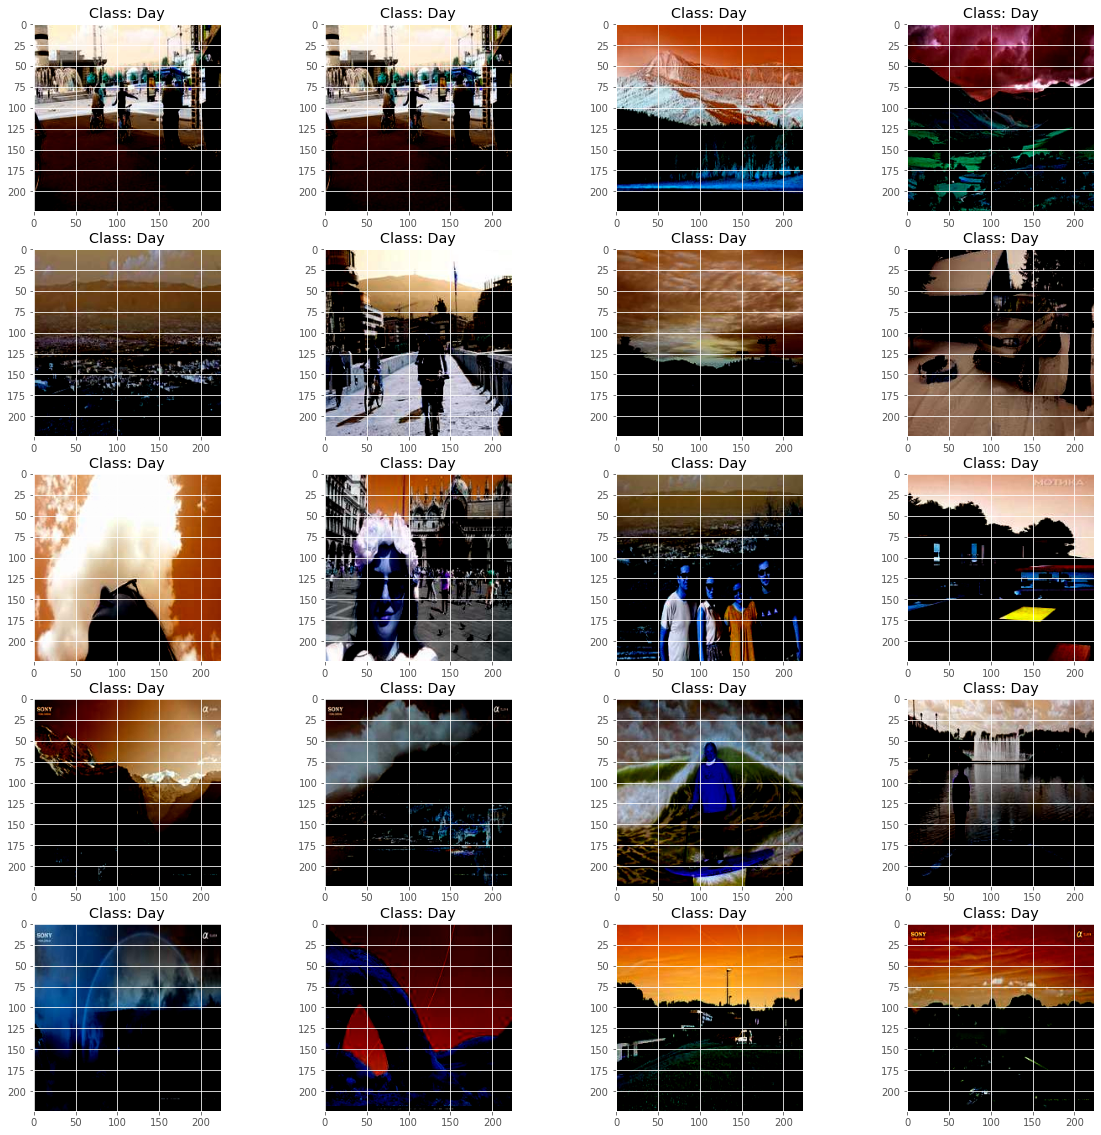

In [29]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,20))

for i in range( 5 * 4 ) :
    # dodavanje na podgrafik
    ax1 = fig.add_subplot( 5, 4, ( i + 1 ) )
    # crtanje na podgrafikot
    ax1.imshow( X_train[ i ] )
    #  dodavanje na tekst na podgrafikot
    title = "Class: " + train_labels[ i ]
    plt.title( title )

# snimanje na grafikot
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

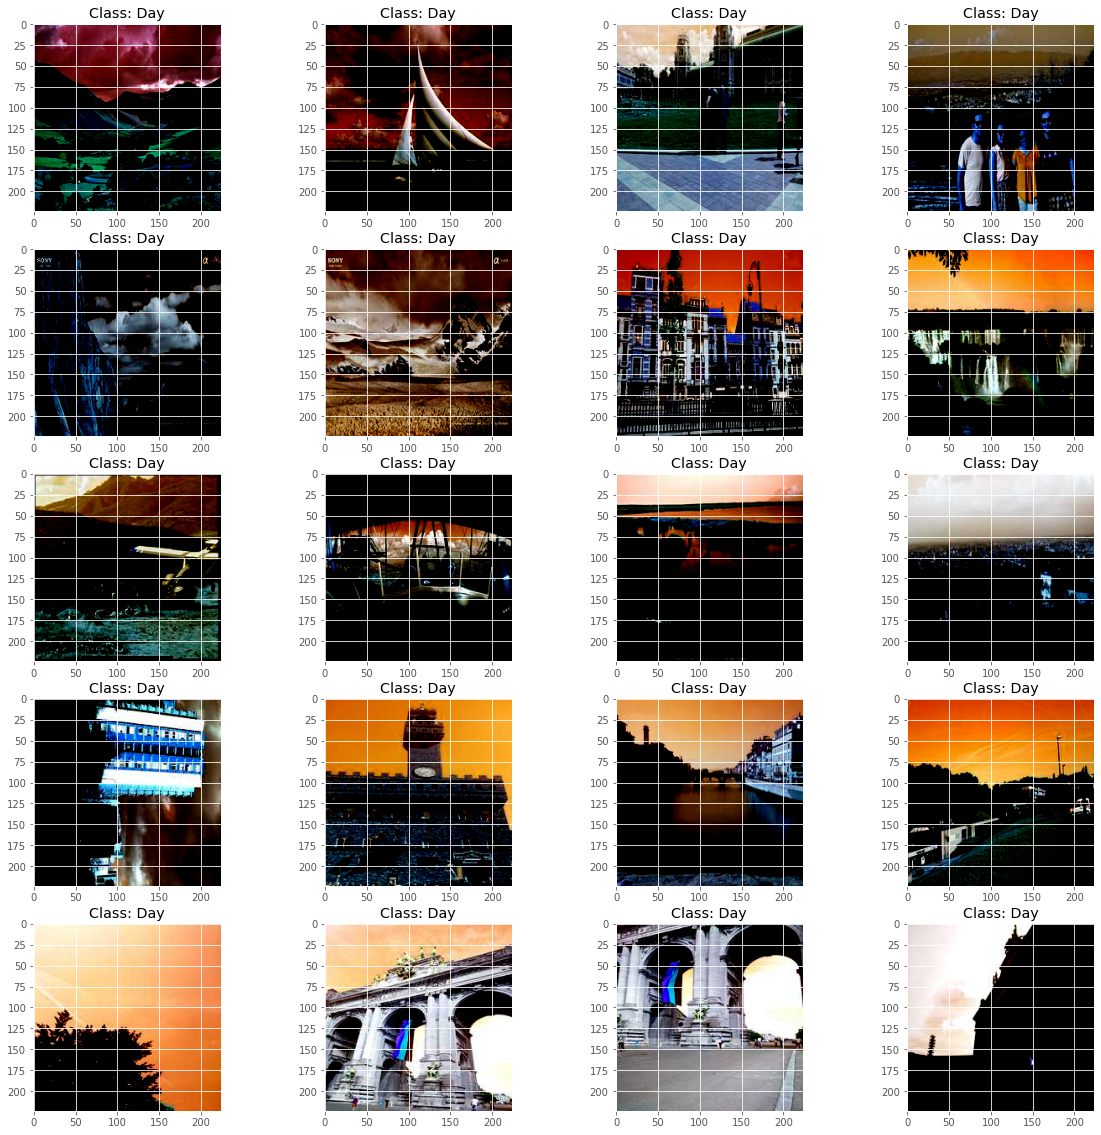

In [30]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,20))

for i in range( 5 * 4 ) :
    # dodavanje na podgrafik
    ax1 = fig.add_subplot( 5, 4, ( i + 1 ) )
    # crtanje na podgrafikot
    ax1.imshow( X_val[ i ] )
    #  dodavanje na tekst na podgrafikot
    title = "Class: " + validation_labels[ i ]
    plt.title( title )

# snimanje na grafikot
plt.show()

# Define Model Architecture

In [ ]:
model_Xception = Xception( include_top = False, input_shape=( 360, 360, 3 ), weights = 'imagenet' )
for layer in model_Xception.layers[ : -5 ] :
  layer.trainable = False
flatten = Flatten()( model_Xception.output )
custom_layer = Dense( 1000, activation = 'relu' )( flatten )
output = Dense( 4, activation = 'softmax' )( custom_layer )

model_Xception = Model( inputs = model_Xception.inputs, outputs = output)

In [ ]:
model_Xception.summary()

# Define Loss Function, Optimizator

In [ ]:
optimzer = keras.optimizers.Adam( lr = 0.00001 )
model_Xception.compile( loss = 'categorical_crossentropy', optimizer = optimzer, metrics = [ 'accuracy' ] )

# Define Augmentator 

In [ ]:
checkpoint = ModelCheckpoint(     
                                'best_model.pt', monitor = 'val_accuracy',
                                verbose = 1, save_best_only = True, mode = 'max'
                               )

model_Xception.fit(
                    np.array(X_train ),
                    np.array(test_y),
                    validation_data = ( data, np.array(validation_y) ),
                    epochs = 25,
                    #callbacks = [ checkpoint ], 
                    batch_size = 40
                        )

# Example :  
   Provide several examples of predictions along with softmax score probability

# Benchmark

# Summary about your results